<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Train-Data-From-NN-Architectures-A-and-B-&amp;-NLP-Features" data-toc-modified-id="Import-Train-Data-From-NN-Architectures-A-and-B-&amp;-NLP-Features-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Train Data From NN Architectures A and B &amp; NLP Features</a></span></li><li><span><a href="#Define-XGBoost-Model-and-Train" data-toc-modified-id="Define-XGBoost-Model-and-Train-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define XGBoost Model and Train</a></span></li><li><span><a href="#Load-Testing-Data-and-Predict-on-it" data-toc-modified-id="Load-Testing-Data-and-Predict-on-it-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Testing Data and Predict on it</a></span></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Importance</a></span></li></ul></div>

# Import Train Data From NN Architectures A and B & NLP Features

In [0]:
import pandas as pd

In [0]:
word2vec_pd = pd.read_csv("train_1_merge_dropout_word2vec.csv").rename(columns={"0":"word2vec"})

In [0]:
multi_merge_pd = pd.read_csv("train_1_merge_dropout.csv").rename(columns={"0":"glover"})

In [0]:
dot_output_pd = pd.read_csv("train_output_merge_dot.csv").rename(columns={"0":"dot_output"})
dot_layer_pd = pd.read_csv("train_dot_layer_merge_dot.csv").rename(columns={"0":"dot_layer"})

In [0]:
manhat_output_pd = pd.read_csv("train_output_merge_manhat.csv").rename(columns={"0":"manhat_output"})
manhat_layer_pd = pd.read_csv("train_merge_manhat.csv").rename(columns={"0":"manhat_layer"})



In [0]:
print(word2vec_pd.shape)
print(multi_merge_pd.shape)
print(dot_output_pd.shape)
print(dot_layer_pd.shape)

(323164, 2)
(323164, 2)
(323164, 2)
(323164, 2)


In [0]:
nlp_pd = pd.read_csv("train_features_34.csv")

In [0]:
nlp_pd.shape

(323164, 35)

In [0]:
result = nlp_pd.merge(multi_merge_pd,on="id",how="inner")\
        .merge(word2vec_pd,on="id",how="inner")\
        .merge(dot_output_pd,on="id",how="inner")\
        .merge(dot_layer_pd,on="id",how="inner")\
        .merge(manhat_output_pd,on="id",how="inner")\
        .merge(manhat_layer_pd,on="id",how="inner")

In [0]:
# Uncomment this if you want the XGBoost Model to no consider the NN outputs 
#result = result.drop(["glover",	"word2vec",	"dot_output",	"dot_layer",	"manhat_output",	"manhat_layer"],axis=1)

In [0]:
train_labels = pd.read_csv("train_labels.csv")
train_labels.head(1)

,id,is_duplicate
0,0,0


In [0]:
train_labels.shape

(323164, 2)

In [0]:
result.columns

Index(['id', 'firstWordSame', 'firstWordSame_fuzzy', 'lastWordSame',
       'lastWordSame_fuzzy', 'embedding_similarity',
       'embedding_similarity_tfidf', 'word_ratio', 'char_ratio',
       'math_similarity', 'token_similarity', 'token_similarity_idf',
       'cross_correlation', 'cross_correlation_idf', 'q1_degree', 'q2_degree',
       'intersection_count', '2grams', '3grams', '4grams', 'edit_score',
       'jaro_score', 'rel_intersection', 'wl_ratio', 'stop_ratio', 'UC_ratio',
       'why', 'what', 'when', 'where', 'how', 'who',
       'embedding_similarity_max', 'embedding_similarity_max_tfidf',
       'entity_score'],
      dtype='object')

In [0]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val= \
    train_test_split(result.drop(["id"],axis=1).as_matrix(),
                     train_labels['is_duplicate'].values,
                     stratify=train_labels['is_duplicate'].values,
                     test_size=0.3, 
                     random_state=2018)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


# Define XGBoost Model and Train

In [0]:
import xgboost as xgb

In [0]:
def train_xg(X_train,y_train,X_val,y_val,feature_names):
  X_train = pd.DataFrame(data=X_train, columns=feature_names)
  X_val = pd.DataFrame(data=X_val, columns=feature_names)
  
  
  dTrain = xgb.DMatrix(X_train, label=y_train)
  dVal = xgb.DMatrix(X_val, label=y_val)

  xgb_params = {
      'objective': 'binary:logistic',
      'booster': 'gbtree',
      'eval_metric': 'auc',
      'eta': 0.1, 
      'max_depth': 4,
      'subsample': 0.9,
      'colsample_bytree': 1 / X_train.shape[1]**0.5,
      'min_child_weight': 10,
      'silent': 1
  }

  bst = xgb.train(xgb_params, dTrain, 1000,  [(dTrain,'train'), (dVal,'val')], 
                  verbose_eval=10, early_stopping_rounds=10)

  return bst

In [0]:
xg1 = train_xg(X_train, y_train, X_val, y_val,result.columns[1:])

[0]	train-auc:0.785377	val-auc:0.781489
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 10 rounds.
[10]	train-auc:0.898664	val-auc:0.895336
[20]	train-auc:0.91161	val-auc:0.908924
[30]	train-auc:0.920625	val-auc:0.918223
[40]	train-auc:0.923727	val-auc:0.921303
[50]	train-auc:0.926131	val-auc:0.923747
[60]	train-auc:0.928018	val-auc:0.925616
[70]	train-auc:0.929839	val-auc:0.92745
[80]	train-auc:0.932348	val-auc:0.929897
[90]	train-auc:0.933307	val-auc:0.930801
[100]	train-auc:0.934443	val-auc:0.931866
[110]	train-auc:0.935418	val-auc:0.932805
[120]	train-auc:0.936501	val-auc:0.933896
[130]	train-auc:0.937198	val-auc:0.934539
[140]	train-auc:0.938029	val-auc:0.935313
[150]	train-auc:0.938691	val-auc:0.935913
[160]	train-auc:0.939466	val-auc:0.936605
[170]	train-auc:0.939814	val-auc:0.936901
[180]	train-auc:0.940348	val-auc:0.937352
[190]	train-auc:0.940713	val-auc:0.937665
[200]	train-auc:0.941045	val-auc:0

# Load Testing Data and Predict on it

In [0]:
test_nlp_df = pd.read_csv("test_features_34.csv")

word2vec_test_pd = pd.read_csv("test_1_multi_merge_dropout_word2vec.csv").rename(columns={"0":"word2vec"})
multi_test_merge_pd = pd.read_csv("test_1_multi_merge_dropout.csv").rename(columns={"0":"glover"})
dot_test_output_pd = pd.read_csv("test_output_merge_dot.csv").rename(columns={"0":"dot_output"})
dot_test_layer_pd = pd.read_csv("test_dot_layer_merge_dot.csv").rename(columns={"0":"dot_layer"})
manhat_test_output_pd = pd.read_csv("test_output_merge_manhat.csv").rename(columns={"0":"manhat_output"})
manhat_test_layer_pd = pd.read_csv("test_merge_manhat.csv").rename(columns={"0":"manhat_layer"})




test_pd = test_nlp_df.merge(multi_test_merge_pd,on="test_id",how="inner")\
        .merge(word2vec_test_pd,on="test_id",how="inner")\
        .merge(dot_test_output_pd,on="test_id",how="inner")\
        .merge(dot_test_layer_pd,on="test_id",how="inner")\
        .merge(manhat_test_output_pd,on="test_id",how="inner")\
        .merge(manhat_test_layer_pd,on="test_id",how="inner")

In [0]:
test_pd.shape

(81126, 41)

In [0]:
test_pd.head()

,test_id,firstWordSame,firstWordSame_fuzzy,lastWordSame,lastWordSame_fuzzy,embedding_similarity,embedding_similarity_tfidf,word_ratio,char_ratio,math_similarity,token_similarity,token_similarity_idf,cross_correlation,cross_correlation_idf,q1_degree,q2_degree,intersection_count,2grams,3grams,4grams,edit_score,jaro_score,rel_intersection,wl_ratio,stop_ratio,UC_ratio,why,what,when,where,how,who,embedding_similarity_max,embedding_similarity_max_tfidf,entity_score,glover,word2vec,dot_output,dot_layer,manhat_output,manhat_layer
0,15,0,0.878981,0,0.208558,0.894801,0.826423,0.941176,0.961039,1,0.218218,0.251041,0.320830,0.291445,11.88,25.08,7.92,0.107143,0.035714,0.0,0.033818,0.739855,0.214286,0.904507,0.796875,0.5,1,0,1,1,0,1,0.520753,0.397651,0.5,0.950391,0.834462,0.869169,0.061864,0.223135,0.163114
1,20,1,1.000000,1,1.000000,0.871040,0.846412,0.714286,0.583333,1,0.507093,0.560377,0.365238,0.339733,1.32,3.96,0.00,0.000000,0.000000,0.0,0.040952,0.671578,0.000000,0.816667,0.933333,1.0,1,1,1,1,1,1,0.743635,0.737955,1.0,0.663217,0.720679,0.321063,3.675625,0.347272,0.278448
2,21,1,1.000000,0,0.455884,0.948524,0.924701,0.700000,0.789474,1,0.478091,0.496458,0.473992,0.453140,1.32,1.32,0.00,0.000000,0.000000,0.0,0.033103,0.716555,0.000000,0.886667,0.816327,0.5,1,1,1,1,1,1,0.634457,0.749039,1.0,0.073192,0.021376,0.560405,2.319438,0.280485,0.220260
3,23,0,0.667701,0,0.636073,0.804563,0.559170,0.636364,0.369565,1,0.000000,0.000000,0.278588,0.217884,1.32,1.32,0.00,0.000000,0.000000,0.0,0.025333,0.514411,0.000000,0.580745,0.785714,1.0,1,1,1,0,0,1,0.411248,0.259039,0.0,0.006703,0.064027,0.057266,6.482089,0.137397,0.052803
4,34,1,1.000000,0,0.200834,0.962578,0.874730,0.750000,0.787879,1,0.866025,0.709542,0.470982,0.441921,1.32,2.64,0.00,0.714286,0.666667,0.6,0.091111,0.926829,0.000000,0.951923,1.000000,1.0,1,1,1,1,1,1,0.803588,0.651903,0.0,0.022149,0.040081,0.692527,1.541097,0.128514,0.038381


In [0]:
test = test_pd.drop(["test_id"],axis=1).as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
test_pd.head(1)

,test_id,firstWordSame,firstWordSame_fuzzy,lastWordSame,lastWordSame_fuzzy,embedding_similarity,embedding_similarity_tfidf,word_ratio,char_ratio,math_similarity,token_similarity,token_similarity_idf,cross_correlation,cross_correlation_idf,q1_degree,q2_degree,intersection_count,2grams,3grams,4grams,edit_score,jaro_score,rel_intersection,wl_ratio,stop_ratio,UC_ratio,why,what,when,where,how,who,embedding_similarity_max,embedding_similarity_max_tfidf,entity_score,glover,word2vec,dot_output,dot_layer,manhat_output,manhat_layer
0,15,0,0.878981,0,0.208558,0.894801,0.826423,0.941176,0.961039,1,0.218218,0.251041,0.32083,0.291445,11.88,25.08,7.92,0.107143,0.035714,0.0,0.033818,0.739855,0.214286,0.904507,0.796875,0.5,1,0,1,1,0,1,0.520753,0.397651,0.5,0.950391,0.834462,0.869169,0.061864,0.223135,0.163114


In [0]:
dTest = xgb.DMatrix(test)
predictions = xg1.predict(dTest, ntree_limit=xg1.best_ntree_limit)

In [0]:
import numpy as np

In [0]:
preds_pd = pd.DataFrame(predictions, columns=["prediction"])
output = pd.concat([test_pd.test_id,preds_pd["prediction"]],axis=1)
output["is_duplicate"] = np.where(output.prediction >= 0.5, 1, 0)
output = output.drop("prediction",axis=1)
output.to_csv("xg_predictions_everything.csv",index=False)

In [0]:
test_pd.to_csv("test_NLP_LSTM.csv")
result.to_csv("train_NLP_LSTM.csv")

# Feature Importance

In [4]:
# Display Feature Importance

#from xgboost import plot_importance
#from matplotlib import pyplot as plt

#fig, ax = plt.subplots(1,1,figsize=(10,10))
#plot_importance(xg1,height=0.4,ax=ax)

**Only NLP Features Used**

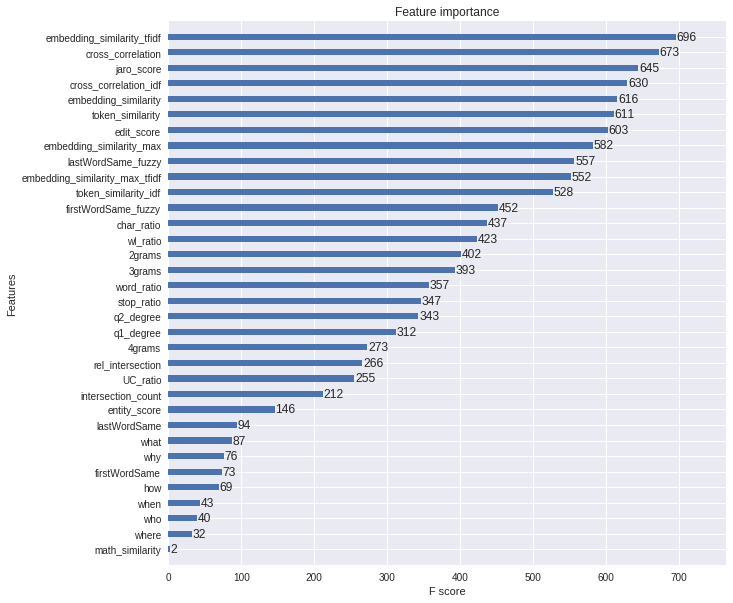

**NLP and NN Model Outputs Used**

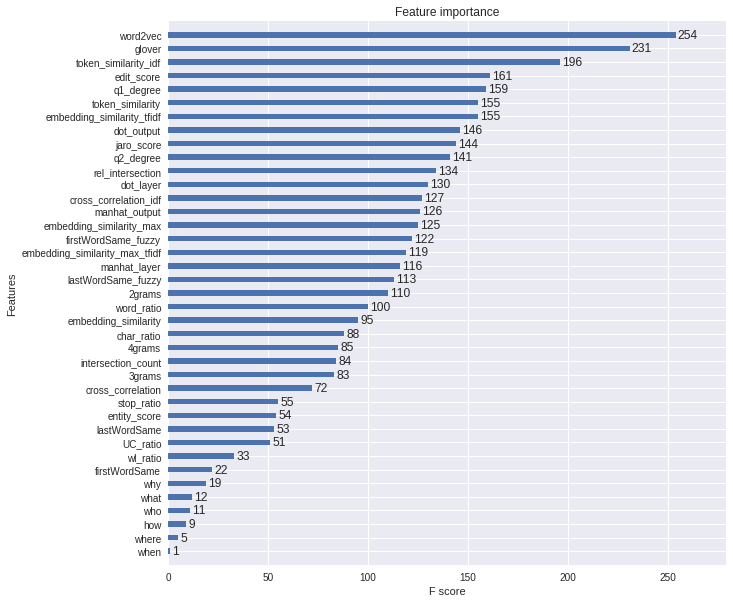